<a href="https://colab.research.google.com/github/miltiadiss/Lung-cancer-classification-from-CT-images-using-exlainability-methods/blob/main/Models/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load neccesary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import cv2

Load training, validation and test sets

In [2]:
training_data = np.load("drive/MyDrive/train.npz")
X_train = training_data["X"]
y_train = training_data["y"]

validation_data = np.load("drive/MyDrive/val.npz")
X_val = validation_data["X"]
y_val = validation_data["y"]

test_data = np.load("drive/MyDrive/test.npz")
X_test = test_data["X"]
y_test = test_data["y"]

Build ViT architecture

In [3]:
def mlp(x, hidden_units, dropout_rate):
    """Simple MLP block used inside the transformer."""
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def build_vit(input_shape=(256, 256, 1), num_classes=3, patch_size=16,
              projection_dim=64, transformer_layers=8, num_heads=4,
              mlp_head_units=[128, 64], dropout_rate=0.1):

    inputs = layers.Input(shape=input_shape)

    # Split into patches
    num_patches = (input_shape[0] // patch_size) ** 2
    patch_dim = patch_size * patch_size * input_shape[2]

    patches = layers.Reshape((num_patches, patch_dim))(inputs)

    # Linear projection of patches
    projected_patches = layers.Dense(projection_dim)(patches)

    # Add positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = projected_patches + pos_embedding

    # Transformer encoder blocks
    for _ in range(transformer_layers):
        # Normalization + Multi-head Self Attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=projection_dim,
                                                     dropout=dropout_rate)(x1, x1)
        x2 = layers.Add()([attention_output, x])

        # MLP block
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=dropout_rate)
        x = layers.Add()([x3, x2])

    # Class token representation
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Classification head
    x = mlp(x, hidden_units=mlp_head_units, dropout_rate=dropout_rate)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

vit_model = build_vit(input_shape=(256,256,1), num_classes=3)

vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

vit_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 256)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256, 64)   │     16,448 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 64)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256, 128)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256, 64)   │      8,256 │ dropout_4[0][0] 

 Total params: 698,947 (2.67 MB)

 Trainable params: 698,947 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

Train for 30 epochs using Early Stopping

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/best_vit_model.keras', save_best_only=True)
]

history_vit = vit_model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 998ms/step - accuracy: 0.3788 - loss: 1.0996 - val_accuracy: 0.3576 - val_loss: 1.0921
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.4537 - loss: 1.0655 - val_accuracy: 0.5515 - val_loss: 0.9968
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5344 - loss: 0.9358 - val_accuracy: 0.5636 - val_loss: 0.9381
Epoch 4/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5397 - loss: 0.8745 - val_accuracy: 0.6000 - val_loss: 0.8166
Epoch 5/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.6448 - loss: 0.7823 - val_accuracy: 0.6061 - val_loss: 0.8142
Epoch 6/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.6621 - loss: 0.7096 - val_accuracy: 0.7273 - val_loss: 0.6137
Epoch 7/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6764 - loss: 0.6945 - val_accuracy: 0.7515 - val_loss: 0.6089
Epoch 8/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7352 - loss: 0.5721 - val_accuracy: 0.7152 -

Plot learning curves for tain, val sets

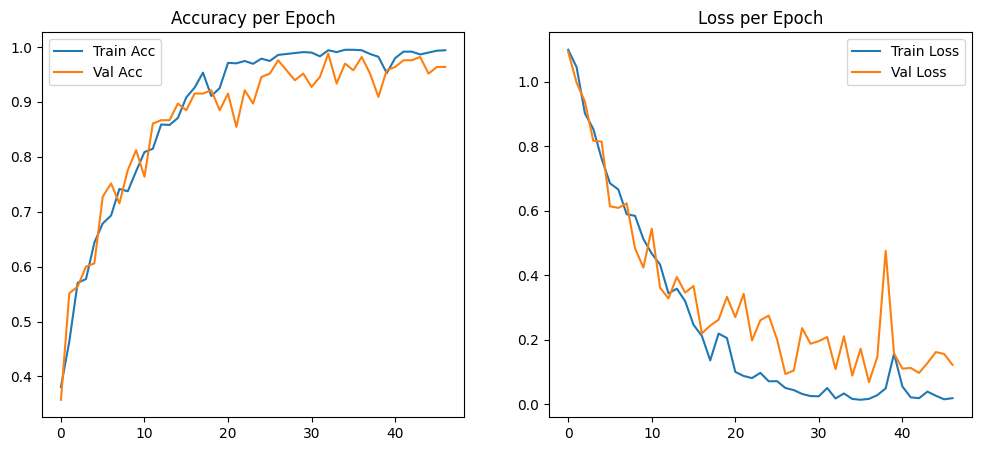

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vit.history['accuracy'], label='Train Acc')
plt.plot(history_vit.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vit.history['loss'], label='Train Loss')
plt.plot(history_vit.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

Evaluate on test set and plot classification report, confusion matrix, ROC curves

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        18
      Normal       0.99      0.98      0.98        85
   Malignant       0.97      0.98      0.98        62

    accuracy                           0.98       165
   macro avg       0.99      0.99      0.99       165
weighted avg       0.98      0.98      0.98       165



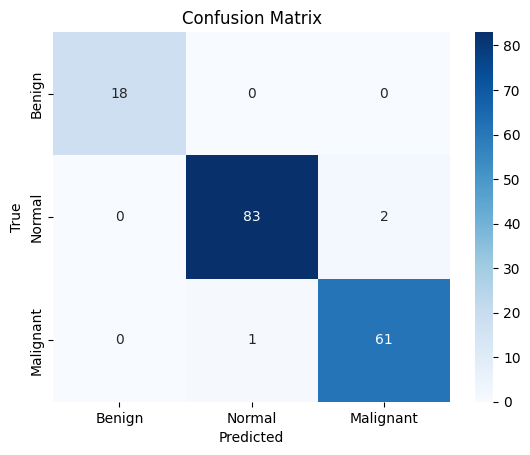

In [8]:
class_mapping = {
  'Benign': 0,
  'Normal': 1,
  'Malignant': 2
}
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

y_pred = np.argmax(vit_model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred, target_names=class_mapping.keys()))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping.keys(),
            yticklabels=class_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


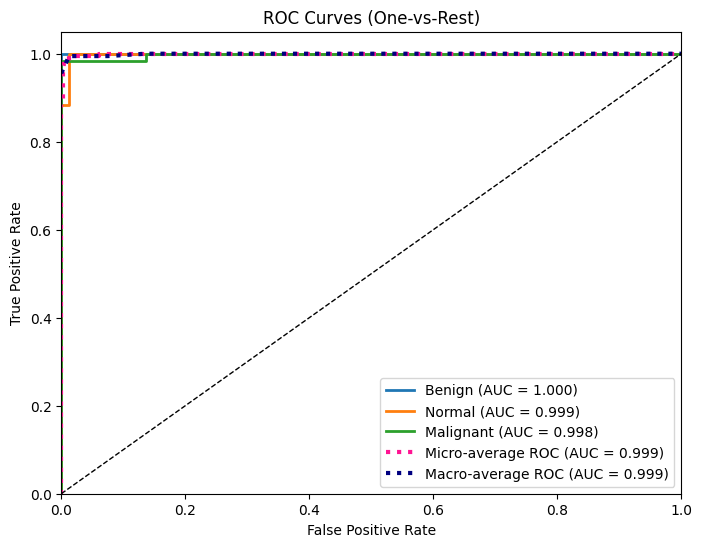

In [9]:
y_pred_proba = vit_model.predict(X_test)   # Get softmax probabilities
y_pred = np.argmax(y_pred_proba, axis=1)

# Label one-hot encoding
n_classes = len(class_mapping)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 6))

for i, (cls, color) in enumerate(zip(class_mapping.keys(), colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{cls} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

Ground truth: Normal (1)
Prediction: Normal (1)
Confidence: 99.96%

Probabilities:
  Benign: 0.01%
  Normal: 99.96%
  Malignant: 0.03%


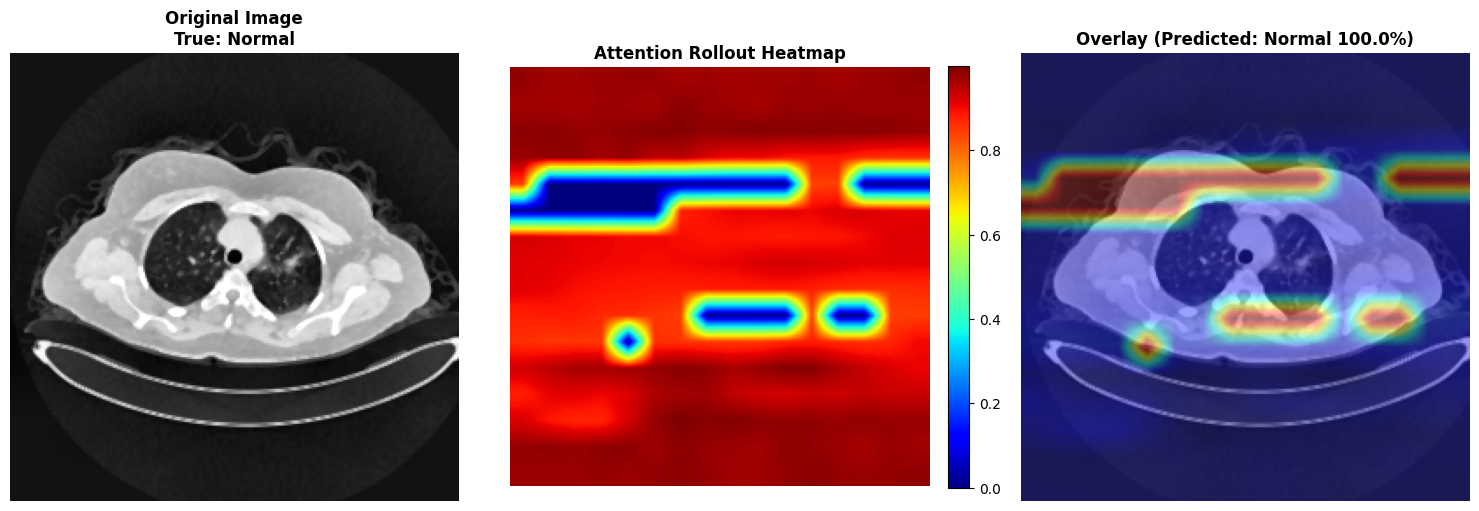

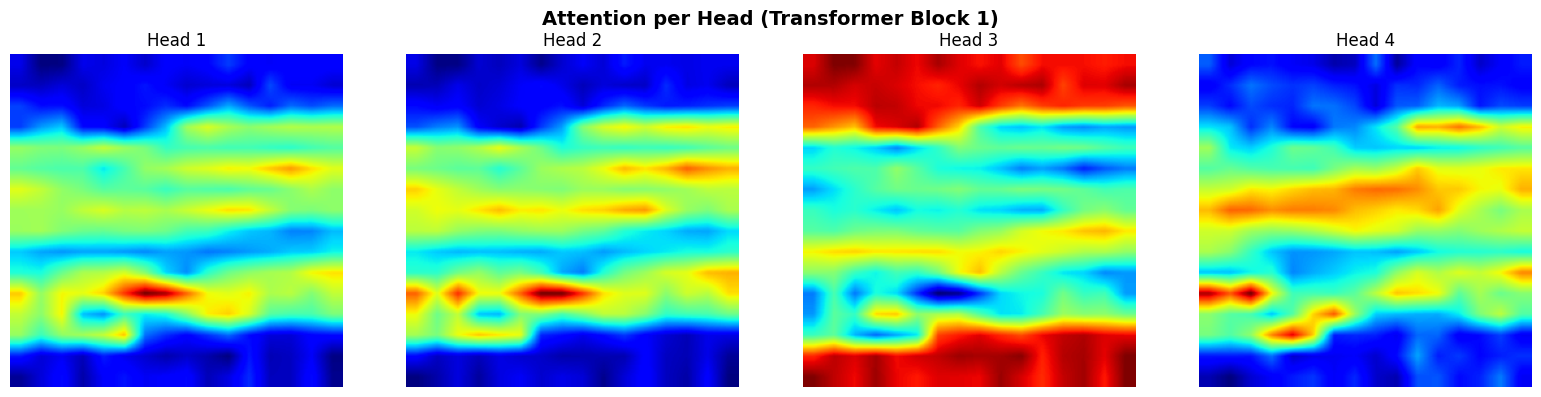

In [10]:
def get_attention_rollout(model, img_array, patch_size=16, head_fusion="mean", discard_ratio=0.1):
    attention_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.MultiHeadAttention)]
    attn_model = tf.keras.Model(inputs=model.input,
                                outputs=[layer.output for layer in attention_layers] + [model.output])

    outputs = attn_model(img_array, training=False)
    attn_outputs = outputs[:-1]

    attn_stack = []
    for attn_out in attn_outputs:
        # Calculate attention "correlation" between patches
        attn = tf.matmul(attn_out, attn_out, transpose_b=True)
        attn = tf.reduce_mean(attn, axis=0)
        attn = attn / (tf.reduce_sum(attn, axis=-1, keepdims=True) + 1e-8)
        attn_stack.append(attn.numpy())

    attn_stack = np.stack(attn_stack, axis=0)

    # Fusion across heads
    if head_fusion == "mean":
        attn_stack = attn_stack.mean(axis=0)
    elif head_fusion == "max":
        attn_stack = attn_stack.max(axis=0)

    # Rollout: multiply all attention matrices
    rollout = np.eye(attn_stack.shape[-1])
    for attn in attn_stack:
        attn = attn + np.eye(attn.shape[-1])
        attn /= attn.sum(axis=-1, keepdims=True)
        rollout = rollout @ attn

    mask = rollout.mean(axis=0)
    threshold = np.quantile(mask, discard_ratio)
    mask[mask < threshold] = 0

    num_patches = int(np.sqrt(mask.shape[0]))
    heatmap = mask.reshape((num_patches, num_patches))
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() + 1e-8)
    return heatmap, rollout

def overlay_heatmap_on_image(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    img_rgb = cv2.cvtColor(np.uint8(255 * img), cv2.COLOR_GRAY2RGB)
    return cv2.addWeighted(img_rgb, 1 - alpha, heatmap, alpha, 0)

def visualize_attention_heads(model, img_array, patch_size=16, block_index=0):
    # Get all MultiHeadAttention layers
    mha_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.MultiHeadAttention)]

    if block_index < 0 or block_index >= len(mha_layers):
        raise ValueError(f"Μη έγκυρος δείκτης block_index={block_index}. Το μοντέλο έχει {len(mha_layers)} MHA layers.")

    mha_layer = mha_layers[block_index]
    attn_model = tf.keras.Model(inputs=model.input, outputs=mha_layer.output)

    # Calculate attention output
    attn_out = attn_model(img_array, training=False).numpy()[0]
    num_heads = mha_layer.num_heads

    patch_tokens = attn_out.shape[0]
    grid_size = int(np.sqrt(patch_tokens))

    # Visualize each head
    fig, axes = plt.subplots(1, num_heads, figsize=(4*num_heads, 4))
    for h in range(num_heads):
        head_map = attn_out[:, h % attn_out.shape[1]]
        head_map = head_map.reshape(grid_size, grid_size)
        head_map = (head_map - head_map.min()) / (head_map.max() + 1e-8)
        axes[h].imshow(cv2.resize(head_map, (img_array.shape[2], img_array.shape[1])), cmap='jet')
        axes[h].set_title(f"Head {h+1}")
        axes[h].axis('off')

    plt.suptitle(f"Attention per Head (Transformer Block {block_index+1})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

idx = np.random.randint(0, len(X_test))
test_img = X_test[idx]
true_label = y_test[idx]
img_array = np.expand_dims(test_img, axis=0)

preds = vit_model.predict(img_array, verbose=0)
pred_class = np.argmax(preds[0])
confidence = preds[0][pred_class]

class_names = {v: k for k, v in class_mapping.items()}
print(f"Ground truth: {class_names[true_label]} ({true_label})")
print(f"Prediction: {class_names[pred_class]} ({pred_class})")
print(f"Confidence: {confidence:.2%}")
print(f"\nProbabilities:")
for i, prob in enumerate(preds[0]):
    print(f"  {class_names[i]}: {prob:.2%}")

# Heatmap & rollouts visualization
heatmap, rollouts = get_attention_rollout(vit_model, img_array, patch_size=16)
overlay = overlay_heatmap_on_image(test_img.squeeze(), heatmap)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_img.squeeze(), cmap='gray')
axes[0].set_title(f"Original Image\nTrue: {class_names[true_label]}", fontsize=12, fontweight='bold')
axes[0].axis('off')

im = axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title("Attention Rollout Heatmap", fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

axes[2].imshow(overlay)
axes[2].set_title(f"Overlay (Predicted: {class_names[pred_class]} {confidence:.1%})",
                  fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Visualize each head from first block
visualize_attention_heads(vit_model, img_array, block_index=0)

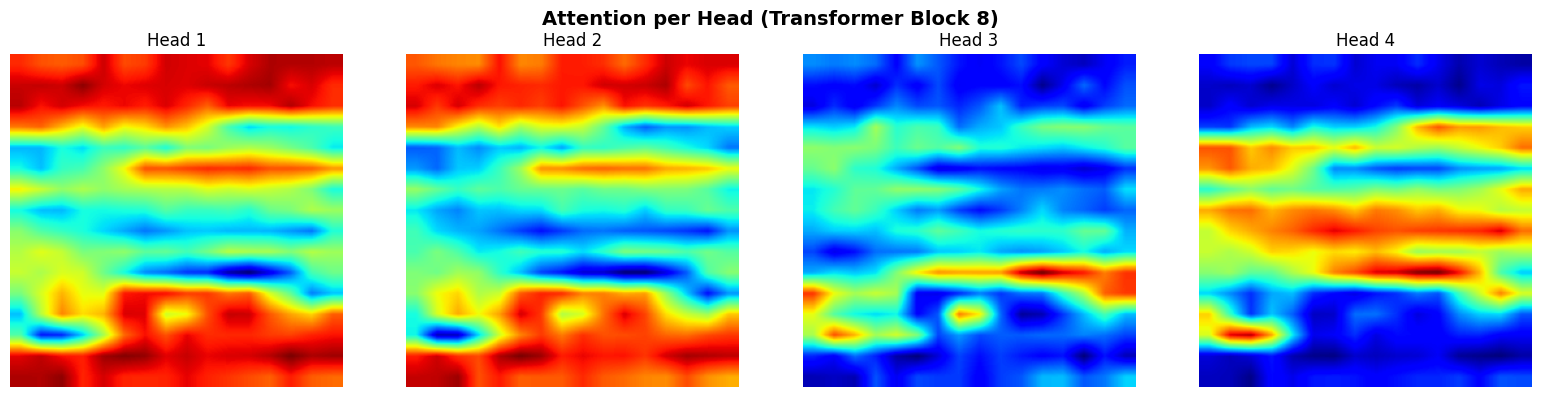

In [11]:
# Visualize also each head from last block (8th)
visualize_attention_heads(vit_model, img_array, block_index=7)